# 제 1차 해커톤 : 캐글 축제

# Predict Future Sals - 미래의 매출 및 판매 예측

### [ 대회 소개 ]
러시아 소프트 회사 중 하나인 1C 회사에서 제공하는 일일 판매 데이터를 가지고, 다음 달의 모든 제품과 매장에 대한 총 매출을 예측해야합니다.

### [ 점수 평가 기준 ]
대회의 평가 방식은 RMSE (Root Mean Squared Error) 입니다.
> RMSE : 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근  

$${\sqrt{ {1 \over N} \sum{(y_t - y_{pr})}^2}}$$

### [ 데이터 설명 ]
- sales_train.csv : 2013년 1월부터 2015년 10월까지의 판매 기록 데이터를 가지는 학습데이터
- test.csv : 2015년 11월 매출 데이터를 가지는 평가데이터
- sample_submission.csv : 캐글제출양식
- items.csv : item(제품)에 대한 추가 정보
- item_categories.csv : item(제품) 카테고리에 대한 추가 정보
- shops.csv : shops(가게)에 대한 추가 정보

> ID : test 데이터 내의 번호  
shop_id : 가게 고유 식별자  
item_id : 제품 고유 식별자  
item_category_id : 제품의 카테고리 고유 식별자  
item_cnt_day : 하루 판매된 제품수  
item_price : 제품의 가격  
date : dd/mm/yyyy 형식의 날짜  
date_block_num : 편의상 사용되는 연속 월 번호 ex) 2013년 1월 : 0, 2013년 2월 : 1, ...  
item_name : 제품 이름  
shop_name : 가게 이름  
item_category_name : 제품의 카테고리 이름  

우리가 예측해야하는 컬럼은 item_cnt_month 입니다.

### [ 목차 ]
### 1. EDA 및 전처리
### 2. 모델링
### 3. 하이퍼파라미터 튜닝
### 4. 결과

## 1. EDA 및 전처리

### 1) 데이터 불러오기

In [1]:
import os
from os.path import join
import pandas as pd 
import numpy as np

data_dir = os.getenv('HOME')+'/aiffel/Hackathon_01/data'

train_path = join(data_dir, 'sales_train.csv')
test_path = join(data_dir, 'test.csv') 
items_path = join(data_dir, 'items.csv') 
item_categories_path = join(data_dir, 'item_categories.csv') 
shops_path = join(data_dir, 'shops.csv') 

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
items_data = pd.read_csv(items_path)
item_categories_data = pd.read_csv(item_categories_path)
shops_data = pd.read_csv(shops_path)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
items = pd.read_csv(items_path)
item_categories = pd.read_csv(item_categories_path)
shops = pd.read_csv(shops_path)

print('train data shape : {}'.format(train.shape))
print('test data shape : {}'.format(test.shape))
print('items data shape : {}'.format(items.shape))
print('item_categories data shape : {}'.format(item_categories.shape))
print('shops data shape : {}'.format(shops.shape))


train data shape : (2935849, 6)
test data shape : (214200, 3)
items data shape : (22170, 3)
item_categories data shape : (84, 2)
shops data shape : (60, 2)


### 2) train 데이터와 test 데이터 살펴보기

In [2]:
print('train data shape : {}'.format(train.shape))

train.info()

train data shape : (2935849, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
print('test data shape : {}'.format(test.shape))

test.info()

test data shape : (214200, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 3) item_price 컬럼 삭제하기

In [6]:
print('제거 전의 train data shape : {}'.format(train.shape))

train.drop('item_price', axis=1, inplace=True)

print('제거 후의 train data shape : {}'.format(train.shape))

train.head()

제거 전의 train data shape : (2935849, 6)
제거 후의 train data shape : (2935849, 5)


,date,date_block_num,shop_id,item_id,item_cnt_day
0,02.01.2013,0,59,22154,1.0
1,03.01.2013,0,25,2552,1.0
2,05.01.2013,0,25,2552,-1.0
3,06.01.2013,0,25,2554,1.0
4,15.01.2013,0,25,2555,1.0


### 4) train 데이터에서 test 데이터에 없는 제품과 가게 없애기

In [7]:
print('제거 전의 train data shape : {}'.format(train.shape))

test_shops = test.shop_id.unique()
test_items = test.item_id.unique()

train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('제거 후의 train data shape : {}'.format(train.shape))

train.head()

제거 전의 train data shape : (2935849, 5)
제거 후의 train data shape : (1224439, 5)


,date,date_block_num,shop_id,item_id,item_cnt_day
0,02.01.2013,0,59,22154,1.0
10,03.01.2013,0,25,2574,2.0
11,05.01.2013,0,25,2574,1.0
12,07.01.2013,0,25,2574,1.0
13,08.01.2013,0,25,2574,2.0


### 5) date 컬럼은 삭제하고 month 컬럼과 year 컬럼 추가하기

In [8]:
print('변경 전의 train data shape : {}'.format(train.shape))

year = train['date'].apply(lambda x : str(x[6:])).astype(int)
month = train['date'].apply(lambda x : str(x[3:5])).astype(int)

train = train.assign(year = year)
train = train.assign(month = month)

train.drop('date', axis=1, inplace=True)

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 5)
변경 후의 train data shape : (1224439, 6)


,date_block_num,shop_id,item_id,item_cnt_day,year,month
0,0,59,22154,1.0,2013,1
10,0,25,2574,2.0,2013,1
11,0,25,2574,1.0,2013,1
12,0,25,2574,1.0,2013,1
13,0,25,2574,2.0,2013,1


### 6) shops.csv 를 통해 city 컬럼 추가하기

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
city = shops["shop_name"].apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])

shops['city'] = city
shops['city_id'] = pd.Categorical(city).codes

shops.head()

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [11]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, shops.loc[:,['shop_id', 'city_id']], on="shop_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 6)
변경 후의 train data shape : (1224439, 7)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id
0,0,59,22154,1.0,2013,1,30
1,0,25,2574,2.0,2013,1,13
2,0,25,2574,1.0,2013,1,13
3,0,25,2574,1.0,2013,1,13
4,0,25,2574,2.0,2013,1,13


### 7) items.csv 를 통해 item_category_id 컬럼 추가하기

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, items.loc[:, ['item_id', 'item_category_id']], on="item_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 7)
변경 후의 train data shape : (1224439, 8)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id,item_category_id
0,0,59,22154,1.0,2013,1,30,37
1,0,25,2574,2.0,2013,1,13,55
2,0,25,2574,1.0,2013,1,13,55
3,0,25,2574,1.0,2013,1,13,55
4,0,25,2574,2.0,2013,1,13,55


### 8) item_categories.csv 를 통해 item_category_id2 컬럼 추가하기

In [14]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
item_category_id2 = item_categories['item_category_name'].apply(lambda x: str(x).split(' ')[0])

item_categories["item_category_name2"] = item_category_id2
item_categories["item_category_id2"] = pd.Categorical(item_category_id2).codes

item_categories.head()

,item_category_name,item_category_id,item_category_name2,item_category_id2
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [16]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, item_categories.loc[:, ['item_category_id', 'item_category_id2']], on="item_category_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 8)
변경 후의 train data shape : (1224439, 9)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id,item_category_id,item_category_id2
0,0,59,22154,1.0,2013,1,30,37,7
1,0,25,2574,2.0,2013,1,13,55,9
2,0,25,2574,1.0,2013,1,13,55,9
3,0,25,2574,1.0,2013,1,13,55,9
4,0,25,2574,2.0,2013,1,13,55,9


### 9) groupby 를 활용하여 item_cnt_month 컬럼 추가하기

In [17]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       33               1.0
                       482              1.0
                       491              1.0
                       839              1.0
                       1007             3.0

In [18]:
group.columns = ['item_cnt_month']

group.head()

item_cnt_month
date_block_num shop_id item_id                
0              2       33                  1.0
                       482                 1.0
                       491                 1.0
                       839                 1.0
                       1007                3.0

In [19]:
group.reset_index(inplace=True)

group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0


In [20]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, group, how='left')
train.drop('item_cnt_day', axis=1, inplace=True)

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 9)
변경 후의 train data shape : (1224439, 9)


,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
0,0,59,22154,2013,1,30,37,7,1.0
1,0,25,2574,2013,1,13,55,9,13.0
2,0,25,2574,2013,1,13,55,9,13.0
3,0,25,2574,2013,1,13,55,9,13.0
4,0,25,2574,2013,1,13,55,9,13.0


### 9) 결측치 제거하기

In [21]:
train.isnull().sum()

date_block_num       0
shop_id              0
item_id              0
year                 0
month                0
city_id              0
item_category_id     0
item_category_id2    0
item_cnt_month       0
dtype: int64

<AxesSubplot:>

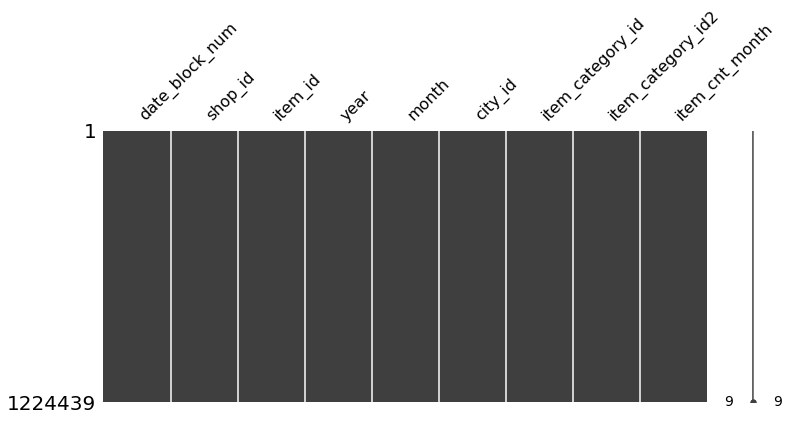

In [22]:
import missingno as msno

msno.matrix(train, figsize=(12,5))

### 10) 중복값 제거하기

In [23]:
print(len(train[train.duplicated()]))
train[train.duplicated()]

624280


,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
2,0,25,2574,2013,1,13,55,9,13.0
3,0,25,2574,2013,1,13,55,9,13.0
4,0,25,2574,2013,1,13,55,9,13.0
5,0,25,2574,2013,1,13,55,9,13.0
6,0,25,2574,2013,1,13,55,9,13.0
...,...,...,...,...,...,...,...,...,...
1224426,33,25,7327,2015,10,13,55,9,2.0
1224433,33,25,7409,2015,10,13,55,9,3.0
1224434,33,25,7409,2015,10,13,55,9,3.0
1224435,33,25,7460,2015,10,13,55,9,3.0


In [24]:
print('중복 제거 전의 train data shape : {}'.format(train.shape))

train.drop_duplicates(inplace=True, ignore_index = True)

print('중복 제거 후의 train data shape : {}'.format(train.shape))

중복 제거 전의 train data shape : (1224439, 9)
중복 제거 후의 train data shape : (600159, 9)


In [25]:
train

,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
0,0,59,22154,2013,1,30,37,7,1.0
1,0,25,2574,2013,1,13,55,9,13.0
2,0,25,2607,2013,1,13,55,9,2.0
3,0,25,2614,2013,1,13,55,9,2.0
4,0,25,2808,2013,1,13,30,5,30.0
...,...,...,...,...,...,...,...,...,...
600154,33,25,7409,2015,10,13,55,9,3.0
600155,33,25,7393,2015,10,13,55,9,1.0
600156,33,25,7384,2015,10,13,55,9,1.0
600157,33,25,7459,2015,10,13,55,9,1.0


### 11) 데이터 시각화

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

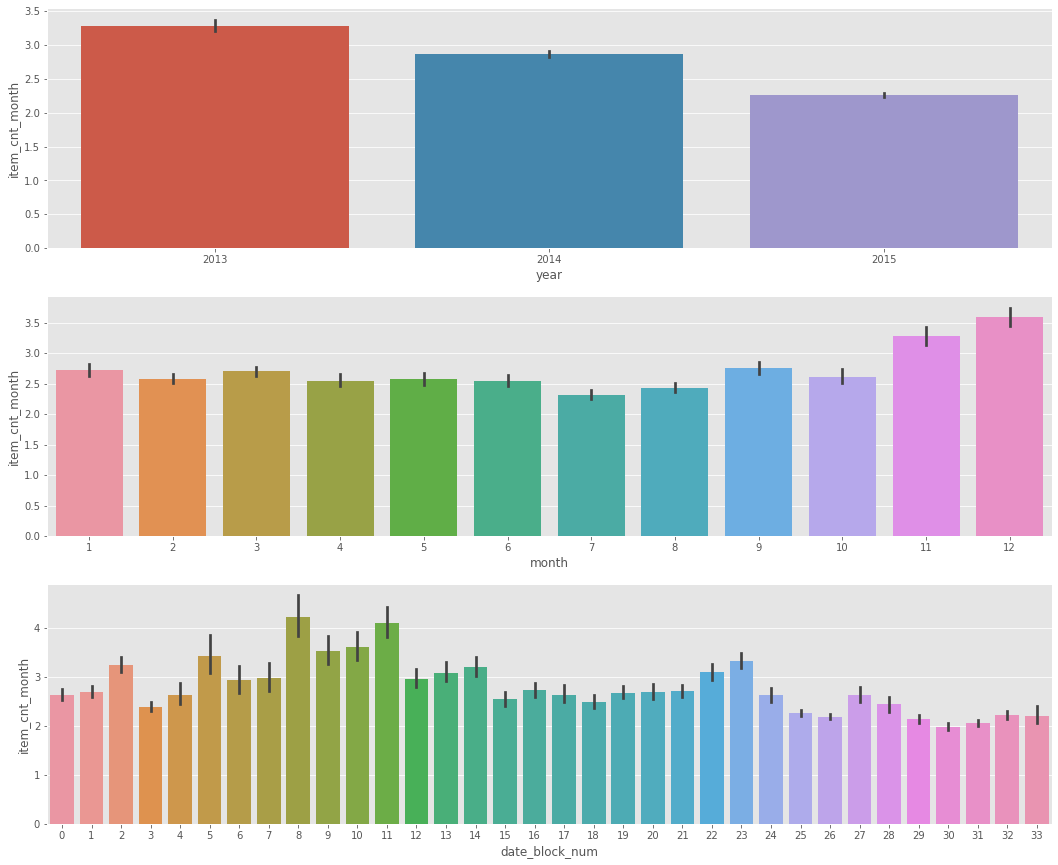

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,15)

sns.barplot(data=train, x="year", y="item_cnt_month", ax=ax1)
sns.barplot(data=train, x="month", y="item_cnt_month", ax=ax2)
sns.barplot(data=train, x="date_block_num", y="item_cnt_month", ax=ax3)


<AxesSubplot:xlabel='shop_id', ylabel='item_cnt_month'>

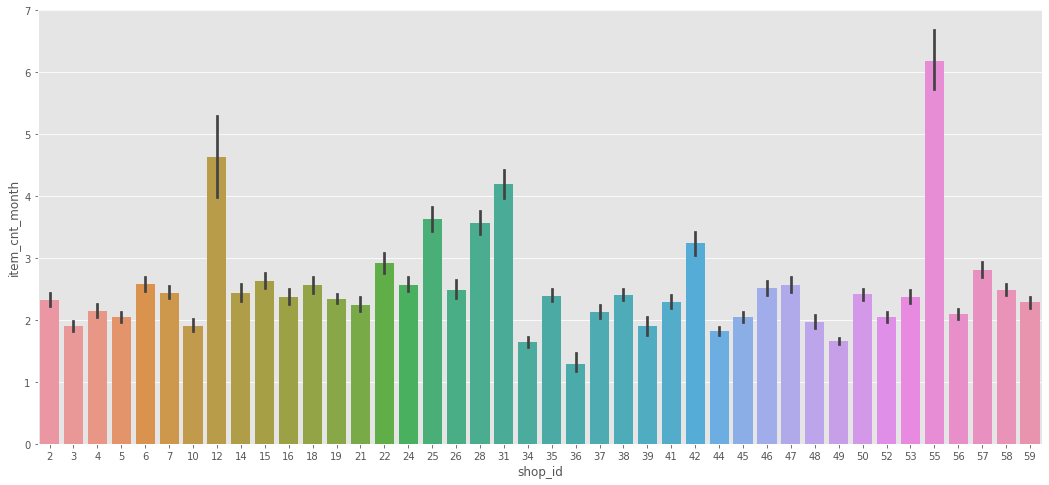

In [27]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="shop_id", y="item_cnt_month")

In [28]:
first = shops['shop_id'] == 53
second = shops['shop_id'] == 12
third = shops['shop_id'] == 31

print(shops[first]["shop_name"].values)   
print(shops[second]["shop_name"].values)
print(shops[third]["shop_name"].values)

['Уфа ТЦ "Семья" 2']
['Интернет-магазин ЧС']
['Москва ТЦ "Семеновский"']


<AxesSubplot:xlabel='city_id', ylabel='item_cnt_month'>

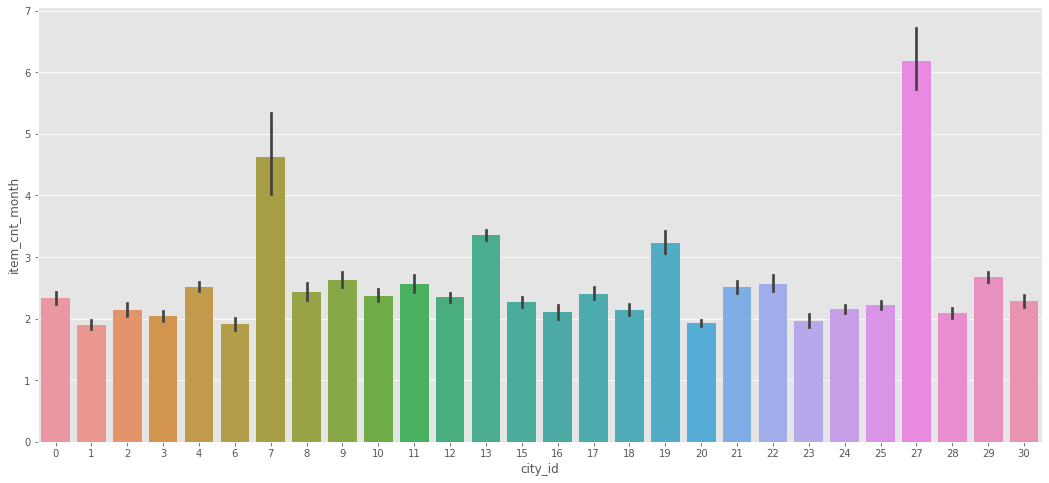

In [29]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="city_id", y="item_cnt_month")

In [30]:
first = shops['city_id'] == 27
second = shops['city_id'] == 7

print(shops[first]["city"].values)
print(shops[second]["city"].values)

['Цифровой']
['Интернет-магазин']


<AxesSubplot:xlabel='item_category_id', ylabel='item_cnt_month'>

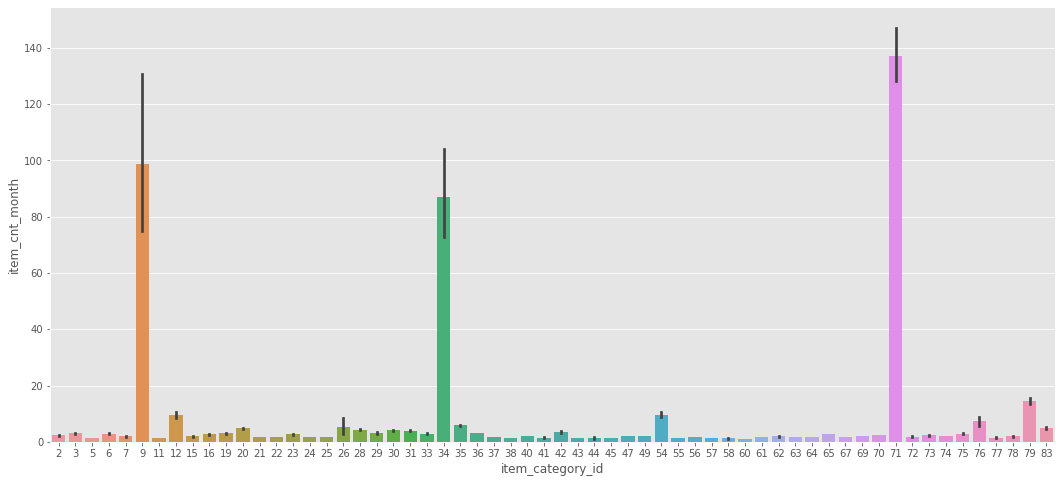

In [31]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="item_category_id", y="item_cnt_month")

In [32]:
first = item_categories['item_category_id'] == 71
second = item_categories['item_category_id'] == 9
third = item_categories['item_category_id'] == 34

print(item_categories[first]["item_category_name"].values)
print(item_categories[second]["item_category_name"].values)
print(item_categories[third]["item_category_name"].values)

['Подарки - Сумки, Альбомы, Коврики д/мыши']
['Доставка товара']
['Карты оплаты - Live! (Цифра)']


<AxesSubplot:xlabel='item_category_id2', ylabel='item_cnt_month'>

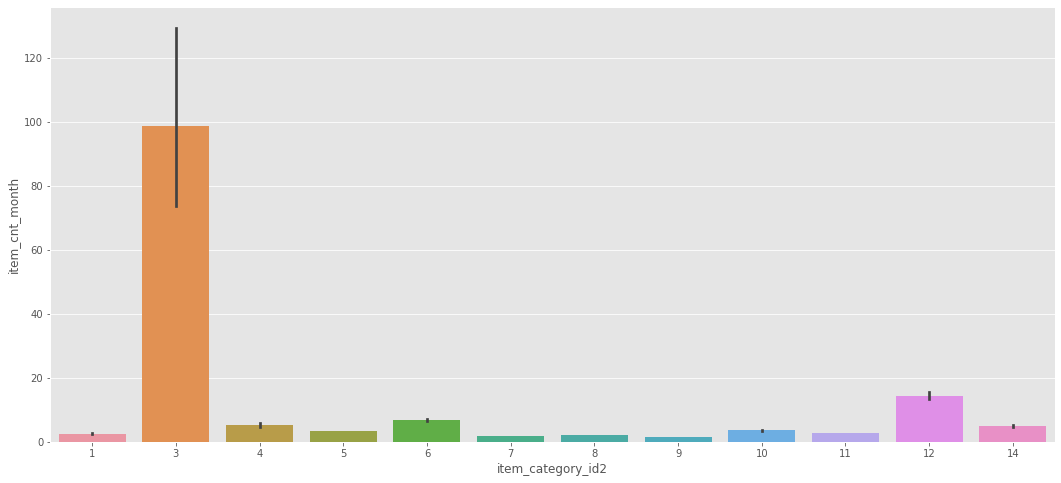

In [33]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="item_category_id2", y="item_cnt_month")

In [34]:
first = item_categories['item_category_id2'] == 3

print(item_categories[first]["item_category_name2"].values)

['Доставка']


<AxesSubplot:xlabel='item_category_id2', ylabel='item_cnt_month'>

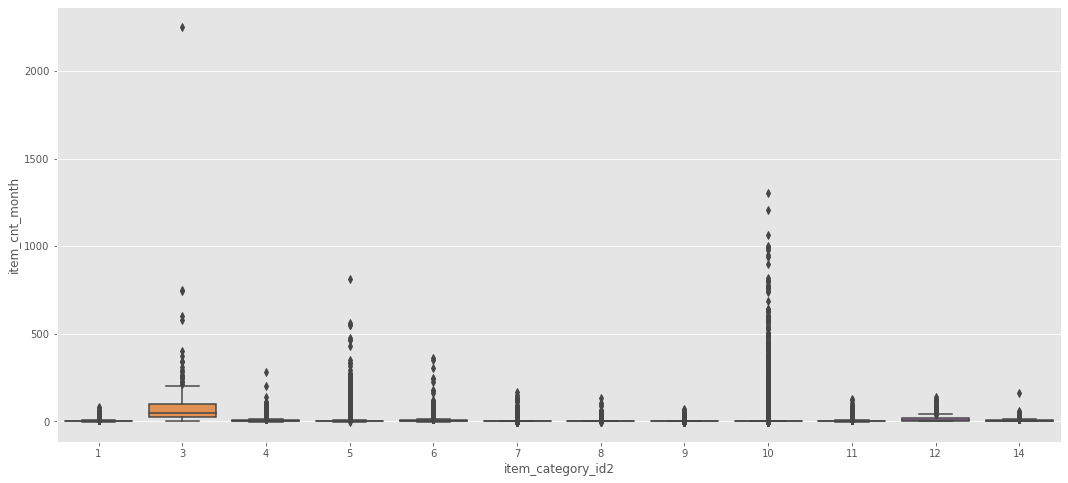

In [35]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id2", y="item_cnt_month")

(0.0, 2500.0)

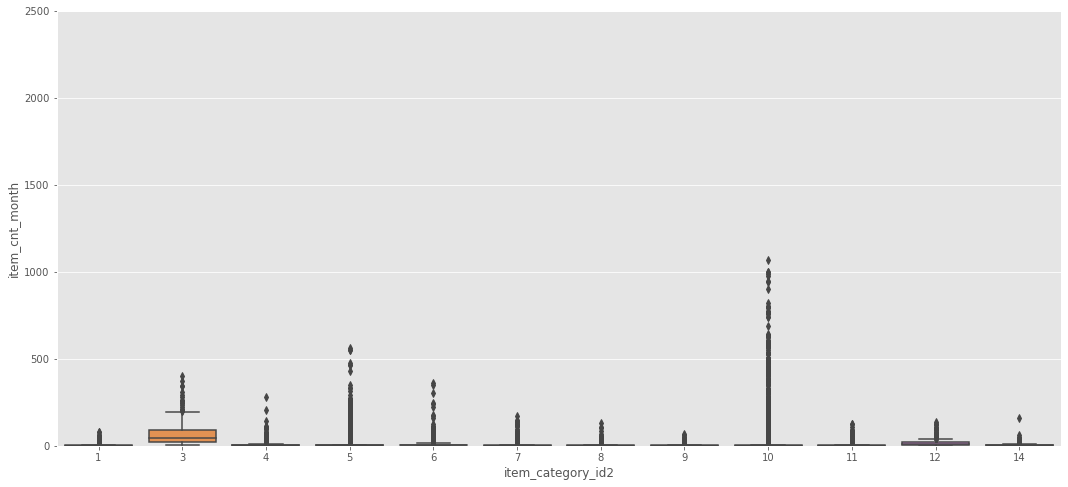

In [36]:
first = train["item_category_id2"] == 3
second = train['item_cnt_month'] > 500
sub = train.drop(train[first & second].index, axis=0)

first = train["item_category_id2"] == 5
second = train['item_cnt_month'] > 700
sub = sub.drop(train[first & second].index, axis=0)

first = train["item_category_id2"] == 10
second = train['item_cnt_month'] > 1200
sub = sub.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=sub, x="item_category_id2", y="item_cnt_month")
plt.ylim(0, 2500)

<AxesSubplot:xlabel='item_category_id', ylabel='item_cnt_month'>

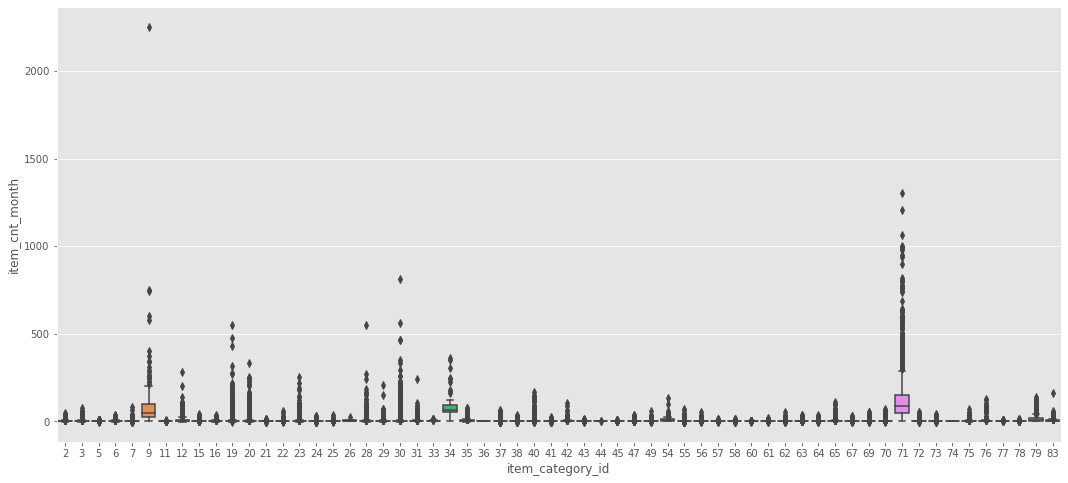

In [37]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id", y="item_cnt_month",orient="v")

(0.0, 2500.0)

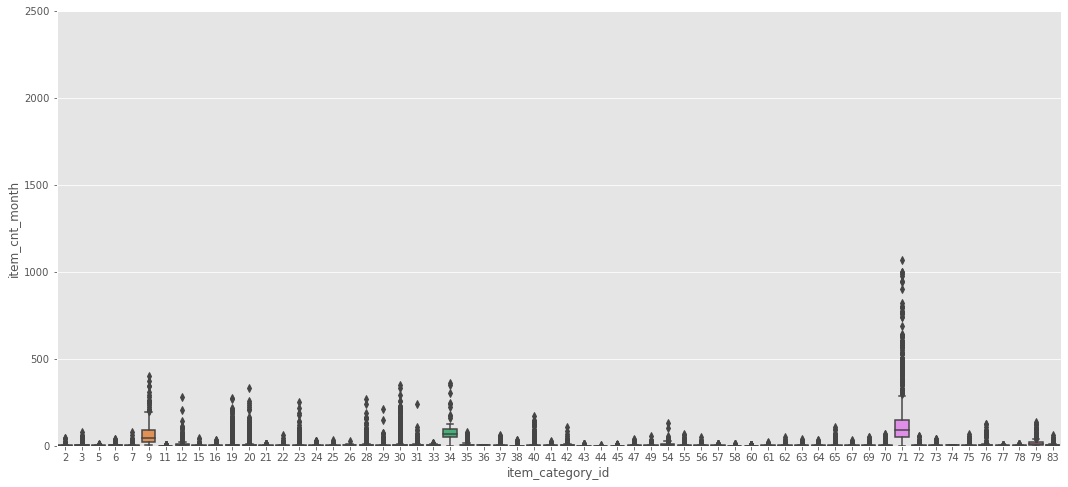

In [38]:
first = train["item_category_id"] == 9
second = train['item_cnt_month'] > 500
sub = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 19
second = train['item_cnt_month'] > 300
sub = sub.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 28
second = train['item_cnt_month'] > 500
sub = sub.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 30
second = train['item_cnt_month'] > 400
sub = sub.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 71
second = train['item_cnt_month'] > 1100
sub = sub.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 83
second = train['item_cnt_month'] > 100
sub = sub.drop(train[first & second].index, axis=0)


fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=sub, x="item_category_id", y="item_cnt_month")
plt.ylim(0, 2500)

<AxesSubplot:xlabel='city_id', ylabel='item_cnt_month'>

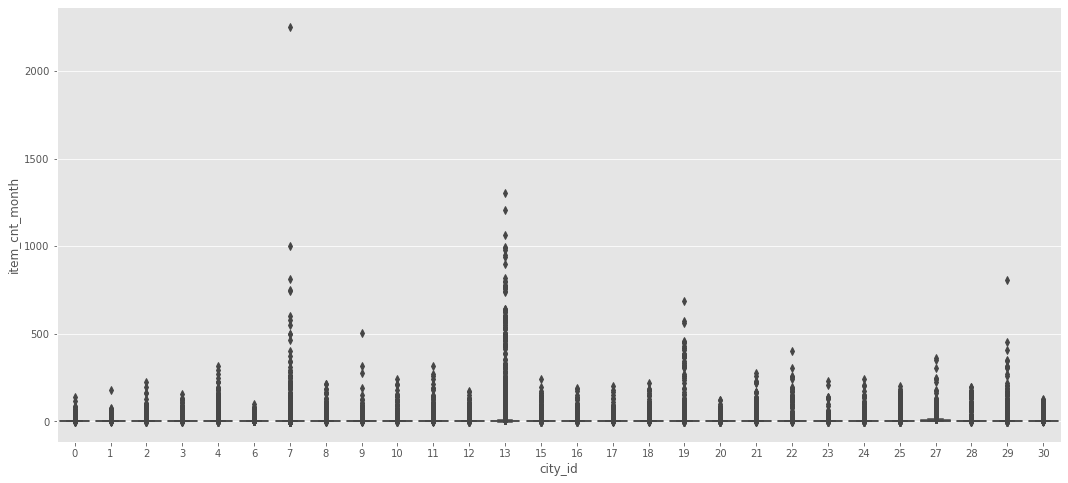

In [39]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="city_id", y="item_cnt_month",orient="v")

(0.0, 2500.0)

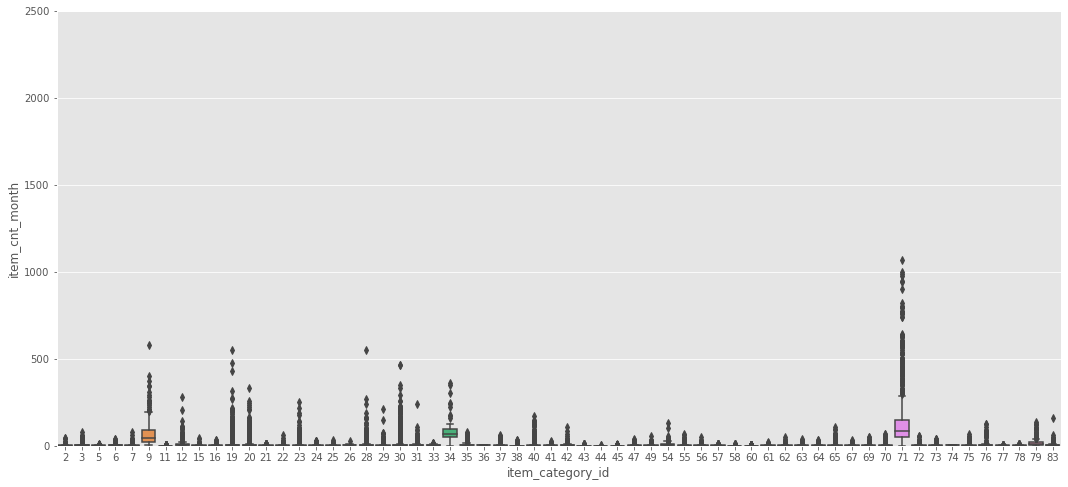

In [40]:
first = train["city_id"] == 7
second = train['item_cnt_month'] > 600
sub = train.drop(train[first & second].index, axis=0)

first = train["city_id"] == 9
second = train['item_cnt_month'] > 400
sub = sub.drop(train[first & second].index, axis=0)

first = train["city_id"] == 13
second = train['item_cnt_month'] > 1100
sub = sub.drop(train[first & second].index, axis=0)

first = train["city_id"] == 19
second = train['item_cnt_month'] > 500
sub = sub.drop(train[first & second].index, axis=0)

first = train["city_id"] == 22
second = train['item_cnt_month'] > 1100
sub = sub.drop(train[first & second].index, axis=0)

first = train["city_id"] == 29
second = train['item_cnt_month'] > 350
sub = sub.drop(train[first & second].index, axis=0)


fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=sub, x="city_id", y="item_cnt_month")
plt.ylim(0, 2500)

<AxesSubplot:xlabel='shop_id', ylabel='item_cnt_month'>

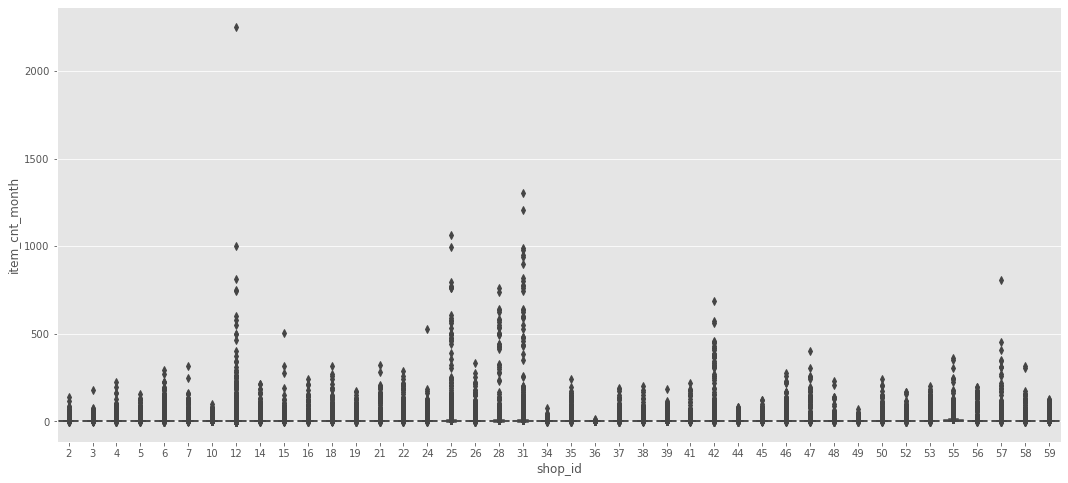

In [41]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="shop_id", y="item_cnt_month")

(0.0, 2500.0)

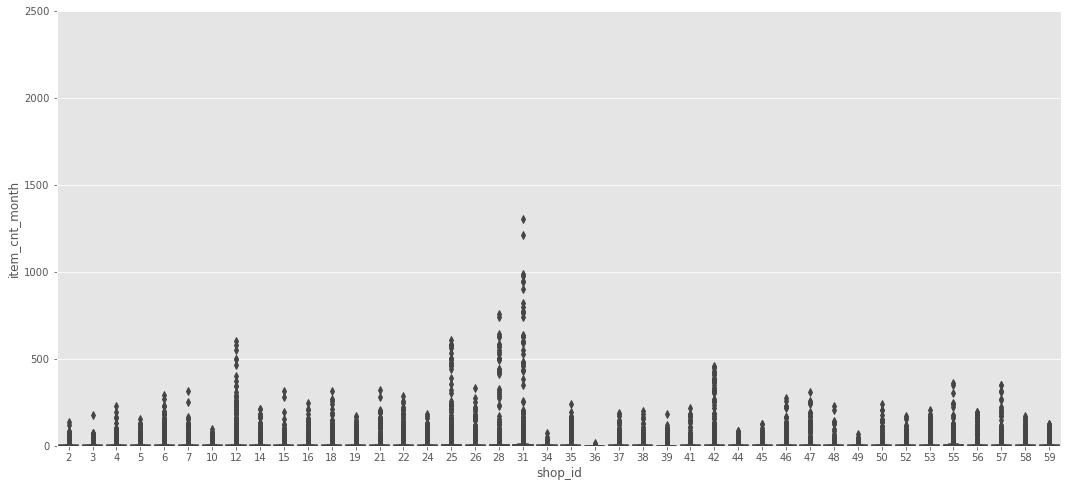

In [42]:
first = train["shop_id"] == 12
second = train['item_cnt_month'] > 650
sub = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 15
second = train['item_cnt_month'] > 400
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 24
second = train['item_cnt_month'] > 400
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 25
second = train['item_cnt_month'] > 650
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 31
second = train['item_cnt_month'] > 1100
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 42
second = train['item_cnt_month'] > 500
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 47
second = train['item_cnt_month'] > 320
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 57
second = train['item_cnt_month'] > 380
sub = sub.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 58
second = train['item_cnt_month'] > 230
sub = sub.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=sub, x="shop_id", y="item_cnt_month")
plt.ylim(0, 2500)

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

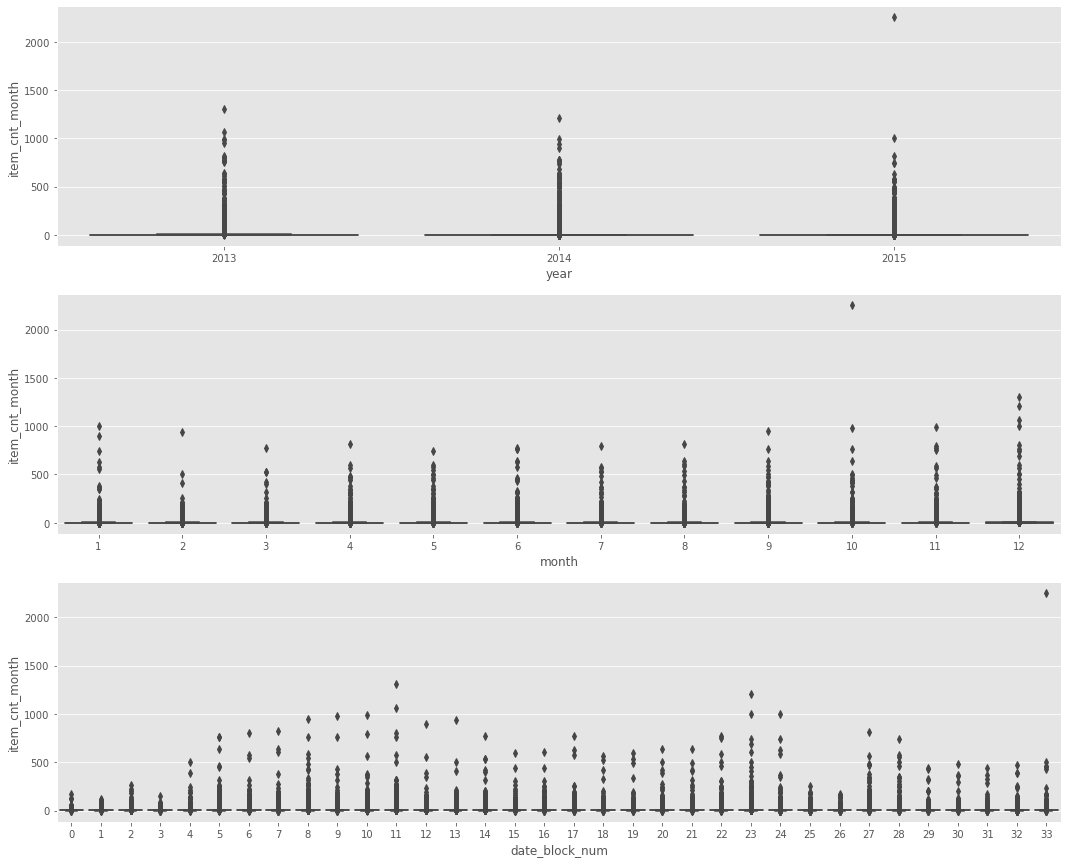

In [43]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,15)

sns.boxplot(data=train, x="year", y="item_cnt_month", ax=ax1)
sns.boxplot(data=train, x="month", y="item_cnt_month", ax=ax2)
sns.boxplot(data=train, x="date_block_num", y="item_cnt_month", ax=ax3)

(0.0, 2500.0)

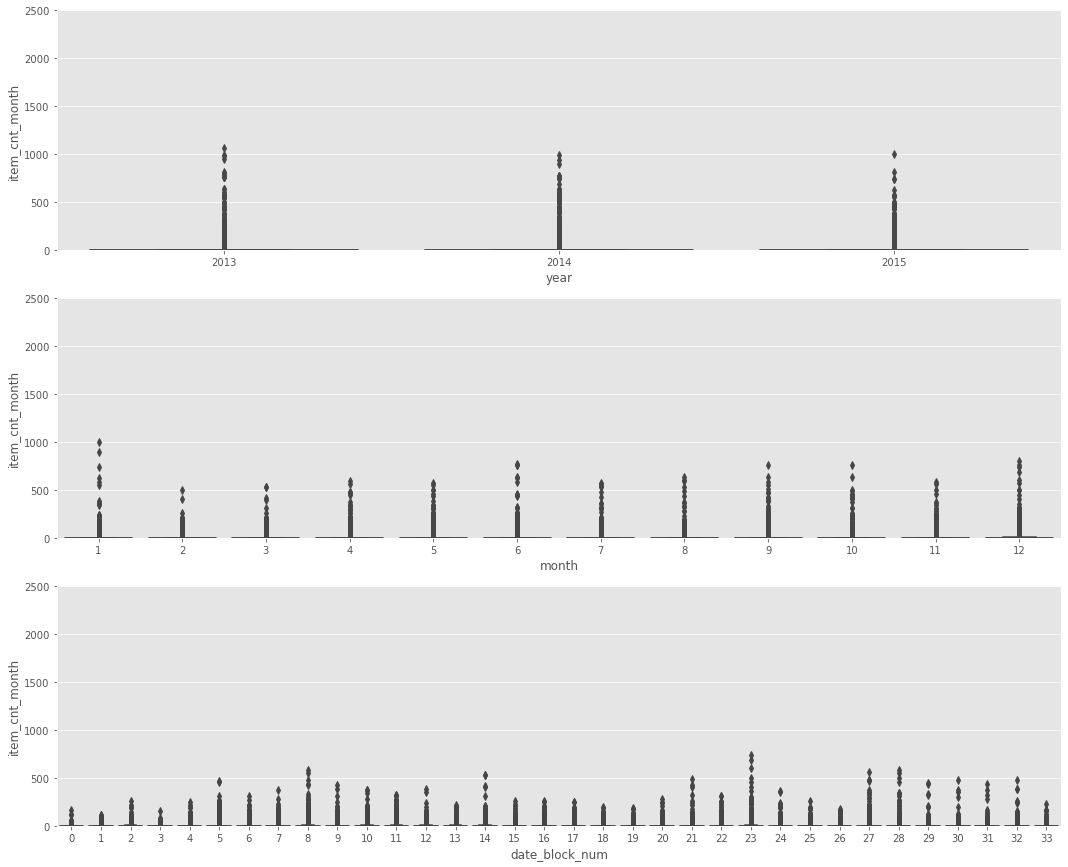

In [51]:
first = train["year"] == 2013
second = train['item_cnt_month'] > 1200
sub1 = train.drop(train[first & second].index, axis=0)

first = train["year"] == 2014
second = train['item_cnt_month'] > 1100
sub1 = sub1.drop(train[first & second].index, axis=0)

first = train["year"] == 2015
second = train['item_cnt_month'] > 1500
sub1 = sub1.drop(train[first & second].index, axis=0)

first = train["month"] == 2
second = train['item_cnt_month'] > 600
sub2 = train.drop(train[first & second].index, axis=0)

first = train["month"] == 3
second = train['item_cnt_month'] > 600
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 4
second = train['item_cnt_month'] > 700
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 5
second = train['item_cnt_month'] > 600
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 7
second = train['item_cnt_month'] > 750
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 8
second = train['item_cnt_month'] > 750
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 9
second = train['item_cnt_month'] > 800
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 10
second = train['item_cnt_month'] > 800
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 11
second = train['item_cnt_month'] > 600
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["month"] == 12
second = train['item_cnt_month'] > 900
sub2 = sub2.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 4
second = train['item_cnt_month'] > 250
sub3 = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 5
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 6
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 7
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 8
second = train['item_cnt_month'] > 600
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 9
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 10
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 11
second = train['item_cnt_month'] > 400
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 12
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 13
second = train['item_cnt_month'] > 250
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 14
second = train['item_cnt_month'] > 600
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 15
second = train['item_cnt_month'] > 300
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 16
second = train['item_cnt_month'] > 300
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 17
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 18
second = train['item_cnt_month'] > 200
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 19
second = train['item_cnt_month'] > 200
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 20
second = train['item_cnt_month'] > 300
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 21
second = train['item_cnt_month'] > 550
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 22
second = train['item_cnt_month'] > 400
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 23
second = train['item_cnt_month'] > 800
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 24
second = train['item_cnt_month'] > 500
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 27
second = train['item_cnt_month'] > 600
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 28
second = train['item_cnt_month'] > 600
sub3 = sub3.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 33
second = train['item_cnt_month'] > 300
sub3 = sub3.drop(train[first & second].index, axis=0)


figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,15)

sns.boxplot(data=sub1, x="year", y="item_cnt_month", ax=ax1)
sns.boxplot(data=sub2, x="month", y="item_cnt_month", ax=ax2)
sns.boxplot(data=sub3, x="date_block_num", y="item_cnt_month", ax=ax3)

ax1.set_ylim(0, 2500)
ax2.set_ylim(0, 2500)
ax3.set_ylim(0, 2500)

In [52]:
y = train["item_cnt_month"]

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_cnt_month', ylabel='Density'>

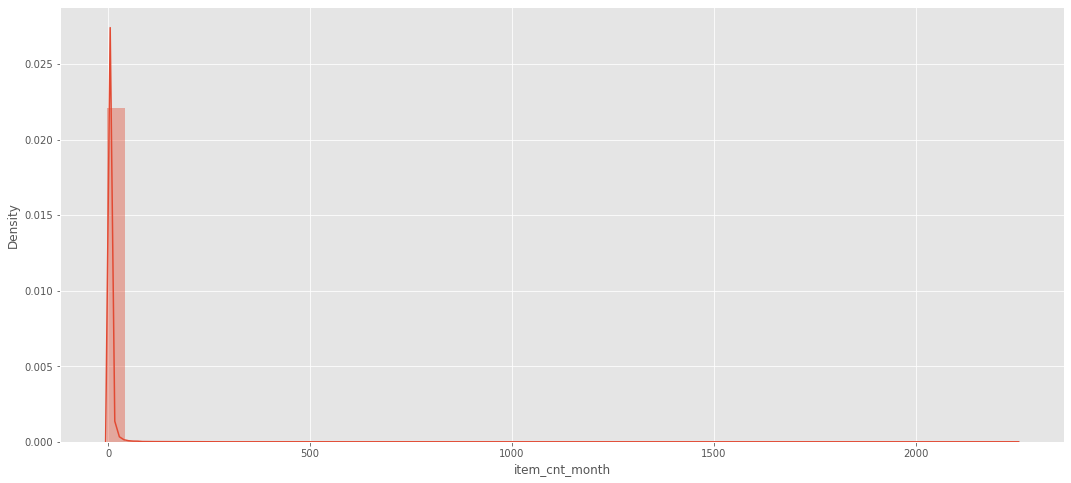

In [53]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.distplot(y)

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_cnt_month', ylabel='Density'>

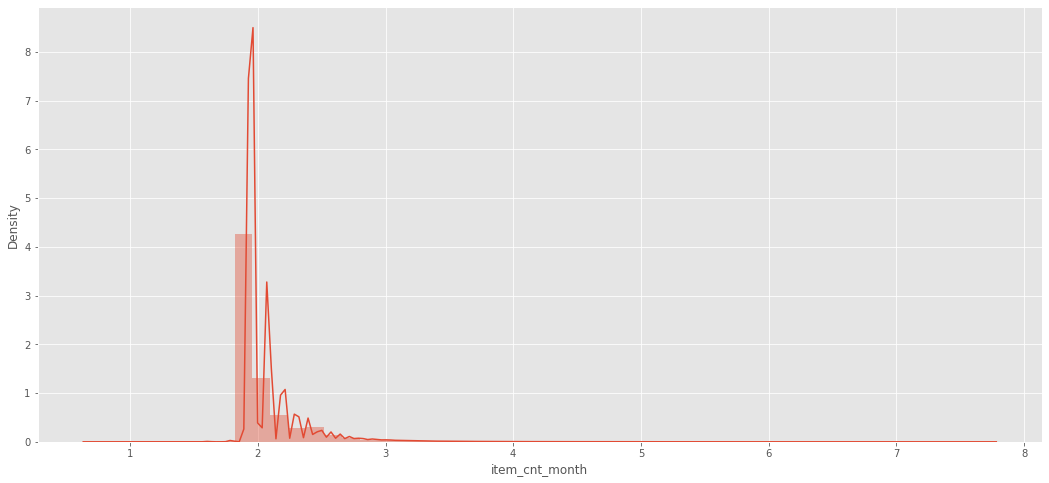

In [54]:
op = np.min(y.values)
y = y - op + 1
y = np.log1p(y)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.distplot(y)

## 3. 하이퍼파라미터 튜닝

### 1) 모델 결정